# Variational Autoencoder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import keras
from keras import backend as k
k.clear_session()

Using TensorFlow backend.


In [2]:
# Set Parameter
image_shape = (28,28,1)
batch_size = 64
latent_dim = 10
epoch = 30

In [3]:
# Import MNIST dataset
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()

In [4]:
# Change datatype and reshape data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + image_shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + image_shape)

In [5]:
# This function will give us 10 labelled handwritten images from 0-9 
def get_10_image(x_train,y_train):
    selected_x,selected_y = [],[]
    for i in range(10):
        number_index = np.where(y_train == i)[0]
        random_index = np.random.choice(len(number_index),1,replace=False)
        select_index = number_index[random_index]
        selected_x.append(x_train[select_index[0]])
        selected_y.append(y_train[select_index][0])
    return np.array(selected_x,dtype="float32").reshape((len(selected_x),)+image_shape),np.array(selected_y,dtype="float32")

In [6]:
selected_x,selected_y =  get_10_image(x_train,y_train)

In [7]:
print(selected_x.shape) # 10 images of 28 x 28
print(selected_y.shape) # 10 labels for each corresponding image

(10, 28, 28, 1)
(10,)


In [8]:
def plot_image(selected_x,selected_y,title=None,save=None):
    ncols = selected_x.shape[0]
    fig,ax  = plt.subplots(nrows=1, ncols=ncols,figsize=(20,3))
    for x,y,ax_i in zip(selected_x,selected_y,ax):
        ax_i.imshow(x.reshape((28,28)))
        ax_i.axis("off")
        ax_i.set_title(int(y))
    if title:
        fig.suptitle(title)
    if save:
        fig.savefig(str(save)+".png")
    plt.show()

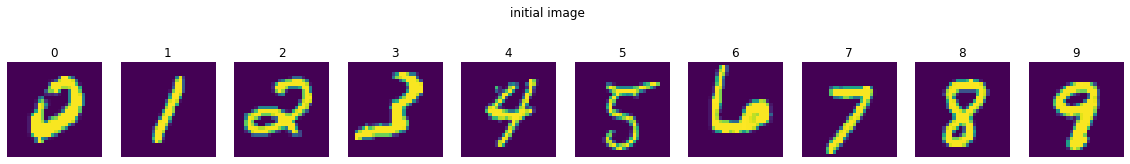

In [9]:
plot_image(selected_x,selected_y,title="initial image",save="initial image")

## Encoder

In [10]:
# input shape = (None,28,28,1)
encoder_input = keras.Input(shape=image_shape)

# input shape = (None,28,28,1)
# output shape = (None,28,28,32)
conv_1 = keras.layers.Conv2D(filters=32,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(encoder_input)

# input shape = (None,28,28,32)
# output shape = (None,28,28,64)
conv_2 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_1)

# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_3 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_2)

# input shape = (None,28,28,64)
# output shape = (None,50176)
flatten = keras.layers.Flatten()(conv_3)

# input shape = (None,50176)
# output shape = (None,128)
encoder_output = keras.layers.Dense(128,activation="relu")(flatten)

2023-01-11 18:44:03.784280: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 18:44:03.784655: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Latent Space 

In [11]:
# input shape = (None,128)
# output shape = (None,latent_dim)
z_mu = keras.layers.Dense(latent_dim)(encoder_output)

# input shape = (None,128)
# output shape = (None,latent_dim)
z_log_sigma = keras.layers.Dense(latent_dim)(encoder_output)

In [12]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = k.random_normal(shape=(k.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + k.exp(z_log_sigma) * epsilon

In [13]:
z = keras.layers.Lambda(sampling,output_shape=(latent_dim,))([z_mu, z_log_sigma])

## Decoder

In [14]:
# input shape = (None,latent_dim)
# output shape = (None,128)
dense_2 = keras.layers.Dense(128,activation="relu")

# input shape = (None,128)
# output shape = (None,50176)
dense_3 = keras.layers.Dense(np.prod(k.int_shape(conv_3)[1:]),activation="relu")

# Reshape layer
# input shape = (None,128)
# output shape = (None,28,28,64)
reshape = keras.layers.Reshape(k.int_shape(conv_3)[1:])

# Deconvolutional layer 1
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_4 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# Deconvolutional layer 2
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_5 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# Deconvolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,32)
conv_6 = keras.layers.Conv2DTranspose(filters=32,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# convolutional layer 4
# input shape = (None,28,28,32)
# output shape = (None,28,28,1)
decoder_output = keras.layers.Conv2D(filters=1,
                                     kernel_size=3,
                                     padding="same",
                                     activation="sigmoid"
                                    )
_dense_2 = dense_2(z)
_dense_3 = dense_3(_dense_2)
_reshape = reshape(_dense_3)
_conv_4 = conv_4(_reshape)
_conv_5 = conv_5(_conv_4)
_conv_6 = conv_6(_conv_5)
_decoder_output = decoder_output(_conv_6)

## Loss Function

In [15]:
def vae_loss(x, z_decoded):
        x = k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        # Reconstruction loss
        Reconstruction_loss = 786*keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -0.5 * k.mean(1 + z_log_sigma - k.square(z_mu) - k.exp(z_log_sigma), axis=-1)
        return Reconstruction_loss + kl_loss

## VAE model

In [16]:
variational_encoder = keras.Model(encoder_input,_decoder_output)
variational_encoder.compile(optimizer='rmsprop',loss=vae_loss)
variational_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

## Plotting Model

In [17]:
keras.utils.plot_model(variational_encoder,to_file="variational_encoder_L{}_E_{}.png".format(latent_dim,epoch),show_shapes=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.